# Reading DF

In [1]:
from google.colab import files

# upload kaggle API key for downloading data (json format)
uploaded = files.upload()
for fn in uploaded.keys():
  print(f"File {fn} was uploaded")

# move kaggle.json into folder where API expects to find it
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle (1).json to kaggle (1).json
File kaggle (1).json was uploaded
mv: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d muratkokludataset/pistachio-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset
License(s): CC-BY-NC-SA-4.0
 49% 13.0M/26.7M [00:00<00:00, 136MB/s]
100% 26.7M/26.7M [00:00<00:00, 184MB/s]


In [5]:
from zipfile import ZipFile
file_path = "/content/pistachio-image-dataset.zip"
with ZipFile(file_path, 'r') as zip_file:
  zip_file.extractall()
  print('Extraction Compelted')

Extraction Compelted


Import Modules

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Flatten, Dropout,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
import cv2
import random

data = []
path = '/content/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio'
for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      data.append((img_array,'Kirmizi_Pistachio',os.path.join(path,img)))
path = '/content/Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio'
for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      data.append((img_array,'Siirt_Pistachio',os.path.join(path,img)))
random.shuffle(data)

# EDA

**Getting Total Number of Images**

In [7]:
len(data)

2148

**Freq of each Category**

In [8]:
label = []
for img in data:
  label.append(img[1])

train_counts = pd.Series(label).value_counts()
train_counts

,count
Kirmizi_Pistachio,1232
Siirt_Pistachio,916


**Distribution of each category**

In [9]:
fig = px.pie(values=train_counts.values, names=train_counts.index,hole=0.425)
fig.update_layout(title='Data Distribution of Data',font_size=15,title_x=0.45,annotations=[dict(text='Pistachio',font_size=18, showarrow=False,height=800,width=700)])
fig.show()

In [10]:
fig = px.bar(x=train_counts.index, y=train_counts.values, color=train_counts.index,
             labels={'x': 'Pistachio Type', 'y': 'Count'})
fig.update_layout(title='Data Distribution Bar Plot', font_size=15, title_x=0.45)
fig.show()


**Samples of Images**

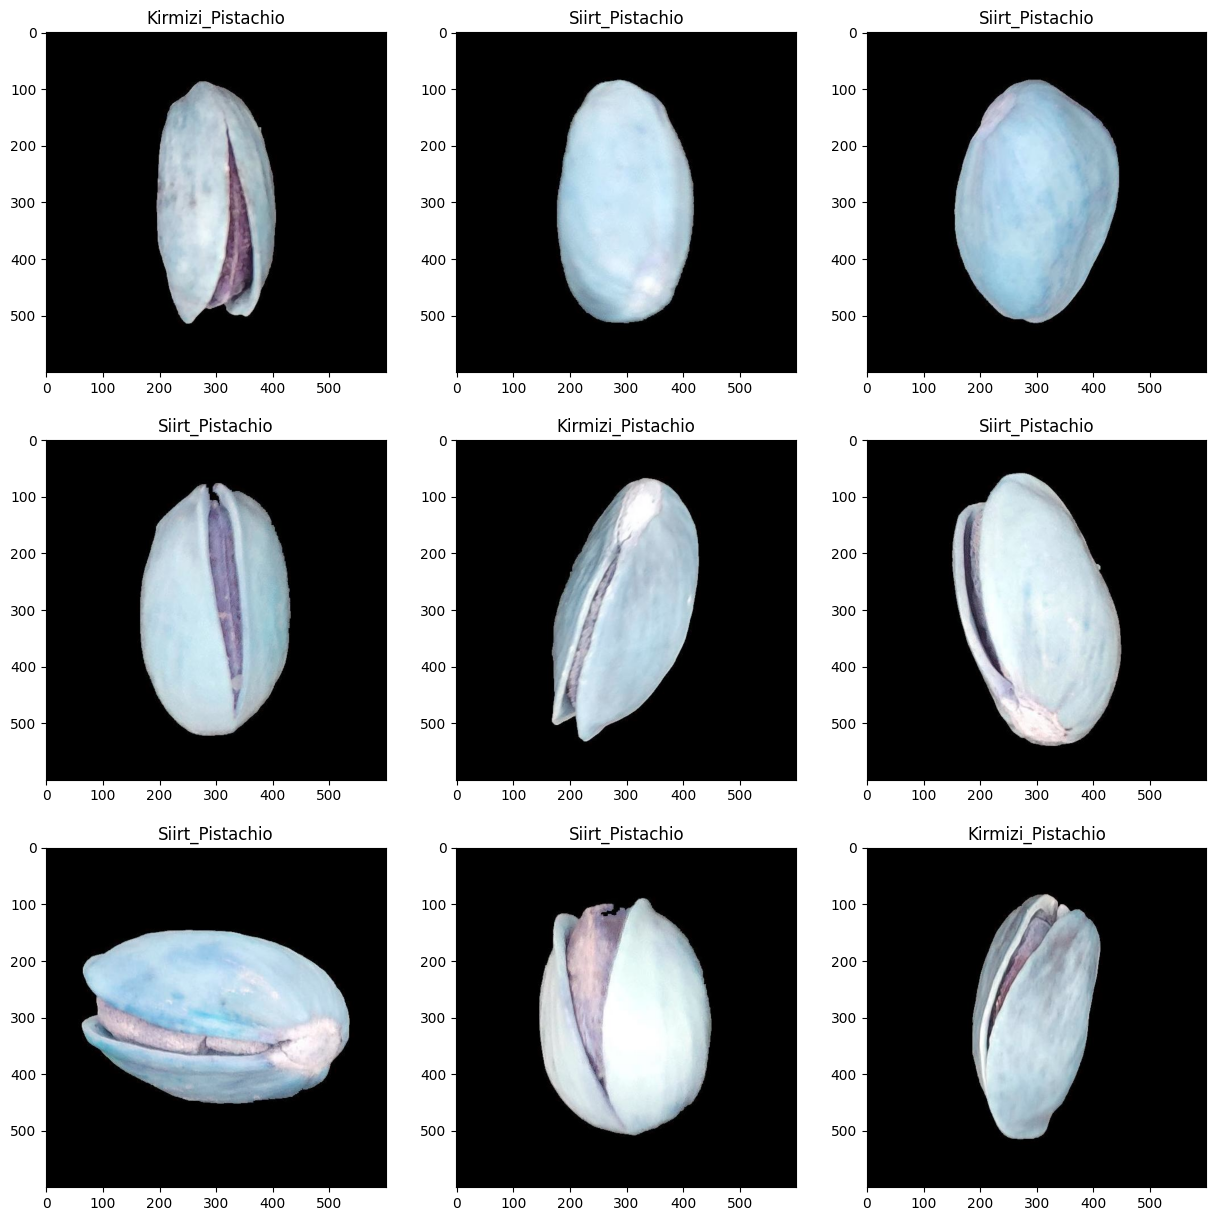

In [11]:
plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(data[i][0])
  plt.title(data[i][1])
plt.show()


**Showing Sizes**

In [12]:
size = []
for img in data:
  size.append(img[0].shape)
set(size)

{(600, 600, 3)}

**Splitting for data**

In [13]:
train = data[:1300]
cv = data[1300:1600]
test = data[1600:]

**Showing Distribution for each one**

In [14]:
train_label = []
for img in train:
  train_label.append(img[1])
train_counts = pd.Series(train_label).value_counts()

cv_label = []
for img in cv:
  cv_label.append(img[1])
cv_counts = pd.Series(cv_label).value_counts()

test_label = []
for img in test:
  test_label.append(img[1])
test_counts = pd.Series(test_label).value_counts()

fig = px.bar(x=["Train", "CV", "Test"], y=[train_counts.values[0], cv_counts.values[0], test_counts.values[0]],
             color=["Train", "CV", "Test"], labels={'x': 'Dataset Split', 'y': 'Kirmizi_Pistachio Count'})
fig.add_bar(x=["Train", "CV", "Test"], y=[train_counts.values[1], cv_counts.values[1], test_counts.values[1]],
            name='Siirt_Pistachio')
fig.update_layout(title='Data Distribution Bar Plot', font_size=15, title_x=0.45)
fig.show()


In [15]:
import plotly.subplots as sp

# Create subplots
fig = sp.make_subplots(rows=1, cols=3, specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

# Pie chart 1 - Train
fig.add_trace(px.pie(values=train_counts.values, names=train_counts.index, hole=0.425).data[0], row=1, col=1)

# Pie chart 2 - CV
fig.add_trace(px.pie(values=cv_counts.values, names=cv_counts.index, hole=0.425).data[0], row=1, col=2)

# Pie chart 3 - Test
fig.add_trace(px.pie(values=test_counts.values, names=test_counts.index, hole=0.425).data[0], row=1, col=3)

# Update layout
fig.update_layout(title='Data Distribution Comparison', font_size=15, title_x=0.45,
                  annotations=[dict(text='Train', font_size=15, showarrow=False, x=0.12, y=0.5),
                               dict(text='CV', font_size=15, showarrow=False, x=0.5, y=0.5),
                               dict(text='Test', font_size=15, showarrow=False, x=0.88, y=0.5)])

fig.show()


**Prepare for Models**

In [16]:
#Splitting data
train_images,train_labels,train_paths = zip(*train)
cv_images,cv_labels,cv_paths = zip(*cv)
test_images,test_labels,test_paths = zip(*test)

#Convert it to numpy array for competions
train_images = np.array(train_images)
cv_images = np.array(cv_images)
test_images = np.array(test_images)

#Label encoding for arrays
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
train_labels = label.fit_transform(train_labels)
cv_labels = label.fit_transform(cv_labels)
test_labels = label.fit_transform(test_labels)

#One Hot Encoding
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
cv_labels = to_categorical(cv_labels)
test_labels = to_categorical(test_labels)

train_images.shape,cv_images.shape,test_images.shape

((1300, 600, 600, 3), (300, 600, 600, 3), (548, 600, 600, 3))

# ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

NN_Model = Sequential([
    Flatten(input_shape=(600, 600, 3)),
    Dense(32,activation='relu',name='Layer1'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64,activation='relu',name='Layer2'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(16,activation='relu',name='Layer4'),
    BatchNormalization(),
    Dense(2, activation='softmax',name='Layer5')  # Use num_classes calculated earlier
])

# Use categorical_crossentropy for one-hot encoded labels
NN_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train neural network model
history = NN_Model.fit(train_images, train_labels, epochs=50, validation_data=(cv_images, cv_labels), batch_size=64)

Epoch 1/50
21/21 [==============================] - 7s 228ms/step - loss: 0.7750 - accuracy: 0.6100 - val_loss: 2.0040 - val_accuracy: 0.4267
Epoch 2/50
21/21 [==============================] - 4s 199ms/step - loss: 0.5711 - accuracy: 0.7262 - val_loss: 2.7569 - val_accuracy: 0.4267
Epoch 3/50
21/21 [==============================] - 4s 201ms/step - loss: 0.5109 - accuracy: 0.7477 - val_loss: 2.2454 - val_accuracy: 0.4267
Epoch 4/50
21/21 [==============================] - 4s 199ms/step - loss: 0.4767 - accuracy: 0.7854 - val_loss: 1.7262 - val_accuracy: 0.4333
Epoch 5/50
21/21 [==============================] - 4s 204ms/step - loss: 0.4586 - accuracy: 0.7938 - val_loss: 1.6047 - val_accuracy: 0.4433
Epoch 6/50
21/21 [==============================] - 4s 204ms/step - loss: 0.4172 - accuracy: 0.8262 - val_loss: 1.2305 - val_accuracy: 0.4900
Epoch 7/50
21/21 [==============================] - 4s 207ms/step - loss: 0.3992 - accuracy: 0.8308 - val_loss: 0.9670 - val_accuracy: 0.5367
Epoch 

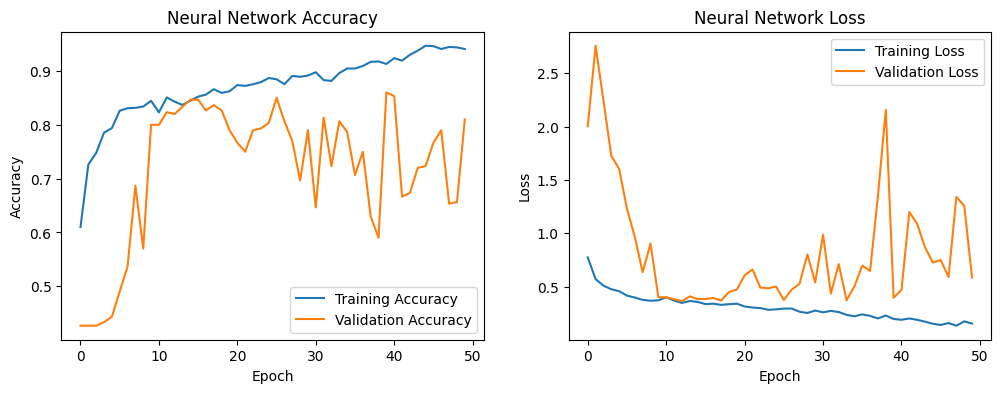

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
nn_test_loss, nn_test_acc = NN_Model.evaluate(test_images, test_labels)
print(f"Neural Network Test Accuracy: {nn_test_acc:.4f}")

18/18 [==============================] - 1s 34ms/step - loss: 0.4484 - accuracy: 0.8613
Neural Network Test Accuracy: 0.8613


**Plotting For Confusion Matrix**

18/18 [==============================] - 1s 33ms/step


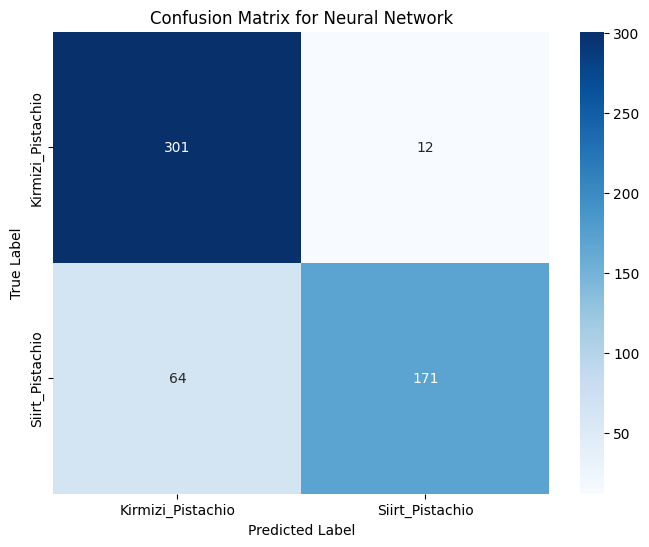

In [ ]:
# Predict probabilities for test data
y_pred_proba = NN_Model.predict(test_images)

# Get predicted labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels
y_true = np.argmax(test_labels, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label.classes_, yticklabels=label.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Neural Network')
plt.show()


**Some Images that Classified Correctly**

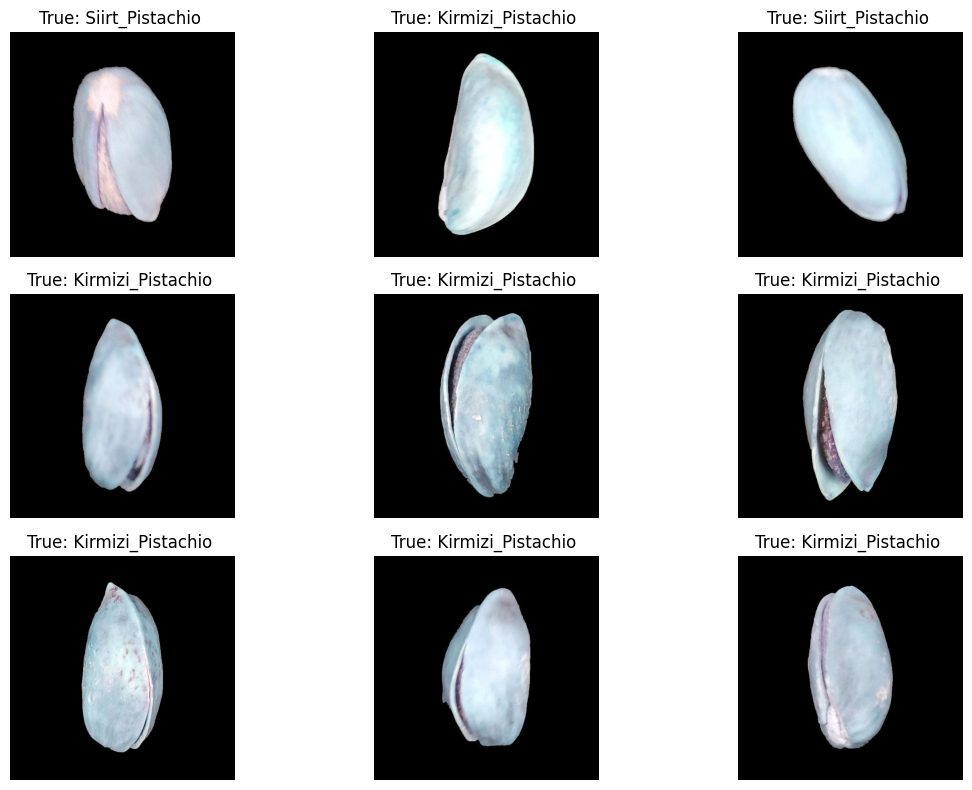

In [ ]:
# Get indices of correctly classified images
correct_indices = np.where(y_pred == y_true)[0]

# Plot some correctly classified images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {label.classes_[y_true[idx]]} ")
    plt.axis('off')

plt.tight_layout()
plt.show()


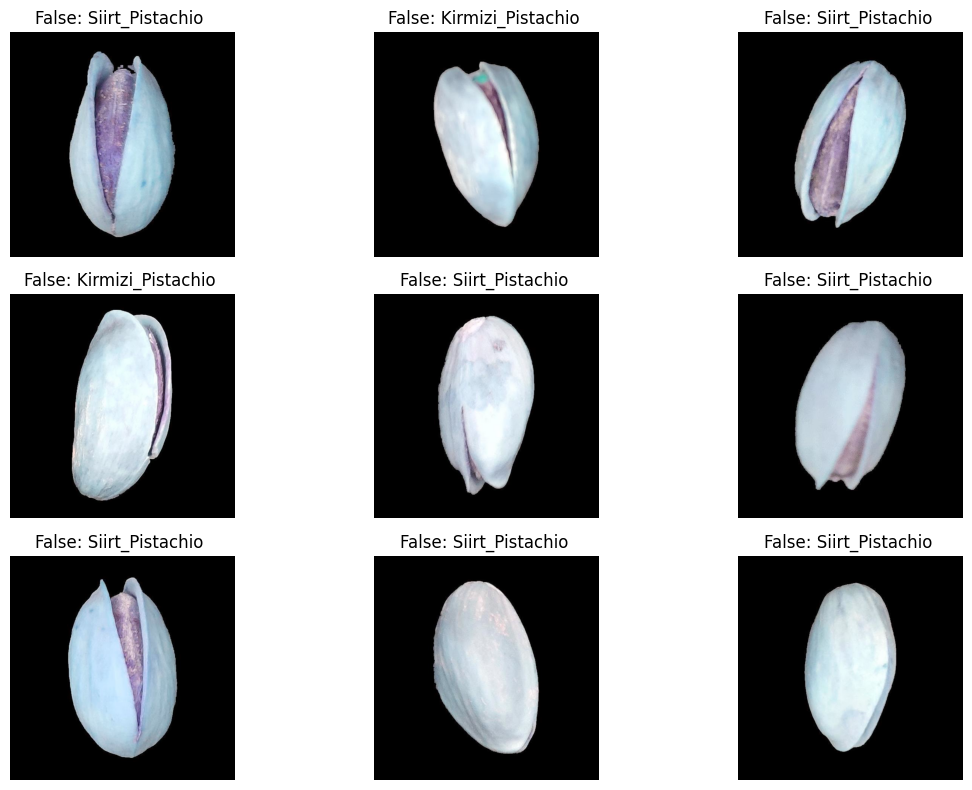

In [ ]:
# Get indices of not correctly classified images
correct_indices = np.where(y_pred != y_true)[0]

# Plot some not correctly classified images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.title(f"False: {label.classes_[y_true[idx]]} ")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Transfer Learning

# **ResNet50**

In [17]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(600, 600, 3))

# Freeze the base model layers
for layer in base_model.layers[:-7]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 0s 0us/step


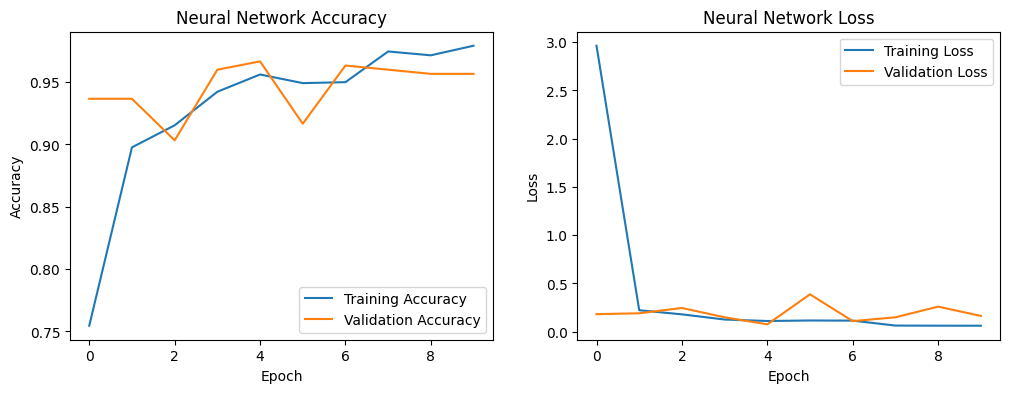

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
resnet_model.evaluate(test_images, test_labels)

18/18 [==============================] - 68s 4s/step - loss: 0.1597 - accuracy: 0.9672


[0.15970154106616974, 0.9671533107757568]

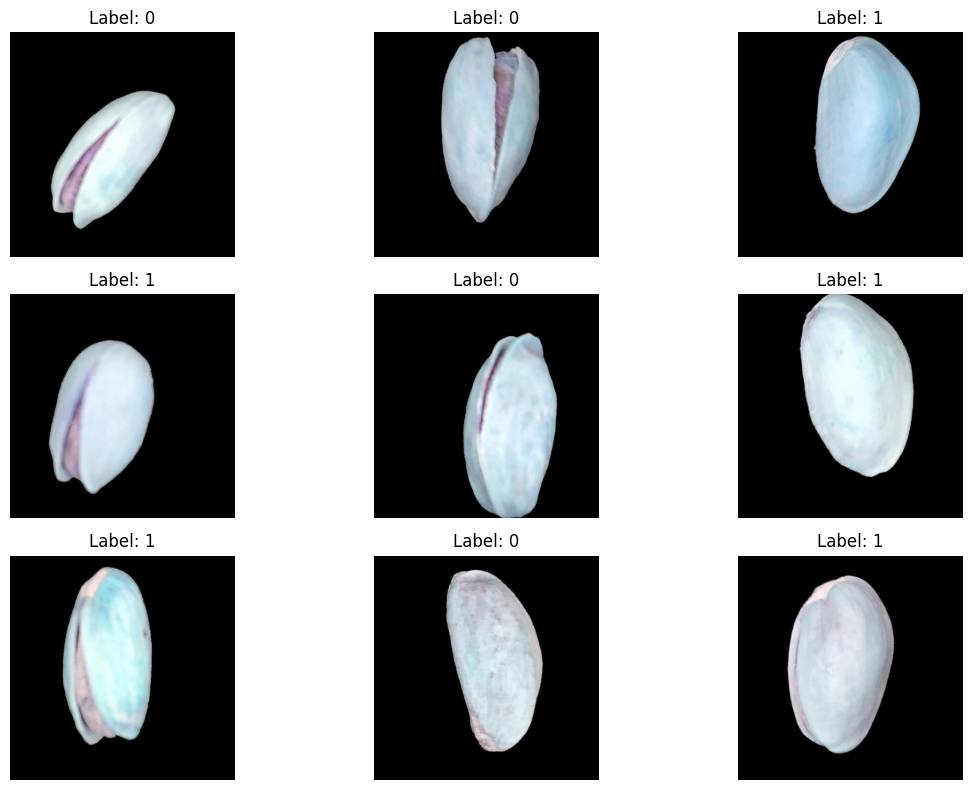

In [18]:
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

cv_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_generator = train_datagen.flow(
    train_images,
    train_labels,
    batch_size=32
)

cv_generator = cv_datagen.flow(
    cv_images,
    cv_labels,
    batch_size=32
)

test_generator = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=32,
    shuffle=False
)

# Show some augmented images
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {np.argmax(y_batch[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [19]:
# Train the model with generated images
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=cv_generator,
    steps_per_epoch=len(train_images) // 32,
    validation_steps=len(cv_images) // 32
)

Epoch 1/10
40/40 [==============================] - 225s 6s/step - loss: 2.3960 - accuracy: 0.5355 - val_loss: 1.2037 - val_accuracy: 0.5799
Epoch 2/10
40/40 [==============================] - 221s 5s/step - loss: 0.6924 - accuracy: 0.5591 - val_loss: 0.7252 - val_accuracy: 0.4340
Epoch 3/10
40/40 [==============================] - 222s 6s/step - loss: 0.6908 - accuracy: 0.5591 - val_loss: 0.6913 - val_accuracy: 0.5729
Epoch 4/10
40/40 [==============================] - 225s 6s/step - loss: 0.6895 - accuracy: 0.5591 - val_loss: 0.6862 - val_accuracy: 0.5903
Epoch 5/10
40/40 [==============================] - 223s 6s/step - loss: 0.6883 - accuracy: 0.5615 - val_loss: 0.6851 - val_accuracy: 0.5833
Epoch 6/10
40/40 [==============================] - 224s 6s/step - loss: 0.6870 - accuracy: 0.5647 - val_loss: 0.6845 - val_accuracy: 0.5799
Epoch 7/10
40/40 [==============================] - 223s 6s/step - loss: 0.6873 - accuracy: 0.5591 - val_loss: 0.6841 - val_accuracy: 0.5764
Epoch 8/10
40

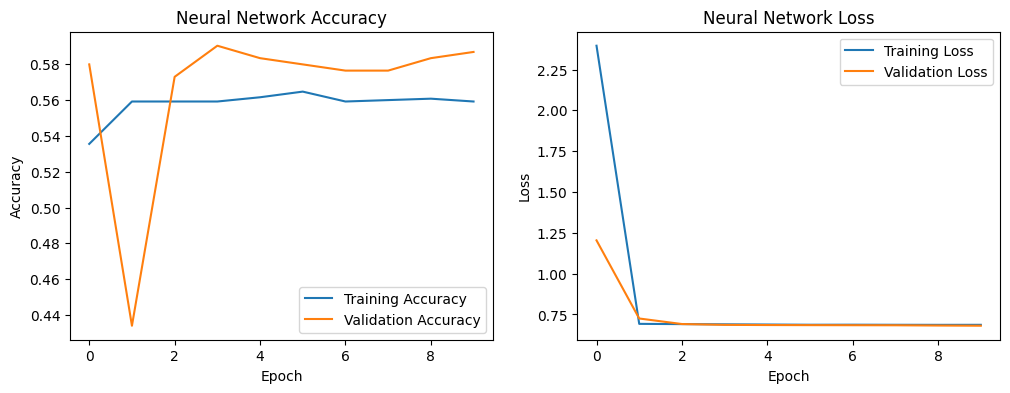

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# VGG16

In [21]:
# prompt: apply VGG16 to original data

from tensorflow.keras.applications import VGG16

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(600, 600, 3))

# Freeze the base model layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = vgg_model.fit(train_images, train_labels, epochs=10, validation_data=(cv_images, cv_labels), batch_size=32)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
41/41 [==============================] - 223s 5s/step - loss: 6919.5225 - accuracy: 0.5654 - val_loss: 0.6880 - val_accuracy: 0.5833
Epoch 2/10
41/41 [==============================] - 222s 5s/step - loss: 0.6879 - accuracy: 0.5608 - val_loss: 0.6828 - val_accuracy: 0.5833
Epoch 3/10
41/41 [==============================] - 223s 5s/step - loss: 0.6863 - accuracy: 0.5608 - val_loss: 0.6804 - val_accuracy: 0.5833
Epoch 4/10
41/41 [==============================] - 224s 5s/step - loss: 0.6860 - accuracy: 0.5608 - val_loss: 0.6809 - val_accuracy: 0.5833
Epoch 5/10
41/41 [==============================] - 225s 6s/step - loss: 0.6861 - accuracy: 0.5608 - val_loss: 0.6800 - val_accuracy: 0.5833
Epoch 6/10
41/41 [==============================] - 225s 6s/step - loss: 0.6858 - accuracy: 0.5608 - val_loss: 0.6799 - val_accuracy: 0.5833
Epoch 7/10
41/41 [==============================] - 226s 6s/step - loss: 0.6861 - accu

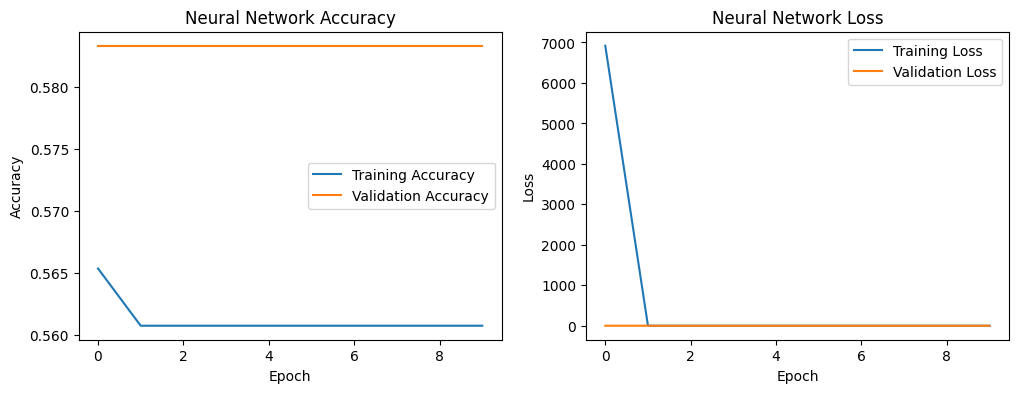

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**VGG16 for augmented images**

In [23]:
# Train the model with generated images
history = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=cv_generator,
    steps_per_epoch=len(train_images) // 32,
    validation_steps=len(cv_images) // 32
)


Epoch 1/10
40/40 [==============================] - 253s 6s/step - loss: 0.6856 - accuracy: 0.5623 - val_loss: 0.6809 - val_accuracy: 0.5799
Epoch 2/10
40/40 [==============================] - 252s 6s/step - loss: 0.6870 - accuracy: 0.5584 - val_loss: 0.6792 - val_accuracy: 0.5868
Epoch 3/10
40/40 [==============================] - 252s 6s/step - loss: 0.6862 - accuracy: 0.5623 - val_loss: 0.6818 - val_accuracy: 0.5799
Epoch 4/10
15/40 [==========>...................] - ETA: 2:16 - loss: 0.6854 - accuracy: 0.5625

KeyboardInterrupt: 

# Inception

In [25]:
# Load the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(600, 600, 3))

# Freeze the base model layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
inception_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = inception_model.fit(train_images, train_labels, epochs=10, validation_data=(cv_images, cv_labels), batch_size=512)


Epoch 1/10
3/3 [==============================] - 76s 25s/step - loss: 57.0999 - accuracy: 0.5262 - val_loss: 66.6043 - val_accuracy: 0.5833
Epoch 2/10
3/3 [==============================] - 70s 24s/step - loss: 45.9054 - accuracy: 0.5531 - val_loss: 49.2546 - val_accuracy: 0.4167
Epoch 3/10
3/3 [==============================] - 70s 24s/step - loss: 30.5554 - accuracy: 0.5123 - val_loss: 25.1669 - val_accuracy: 0.5833
Epoch 4/10
3/3 [==============================] - 71s 24s/step - loss: 21.3269 - accuracy: 0.5900 - val_loss: 2.6721 - val_accuracy: 0.6967
Epoch 5/10
3/3 [==============================] - 70s 24s/step - loss: 5.5097 - accuracy: 0.6054 - val_loss: 4.9041 - val_accuracy: 0.4567
Epoch 6/10
3/3 [==============================] - 71s 24s/step - loss: 3.6995 - accuracy: 0.5500 - val_loss: 1.9164 - val_accuracy: 0.6600
Epoch 7/10
3/3 [==============================] - 71s 24s/step - loss: 1.8686 - accuracy: 0.6185 - val_loss: 0.9314 - val_accuracy: 0.6333
Epoch 8/10
3/3 [====

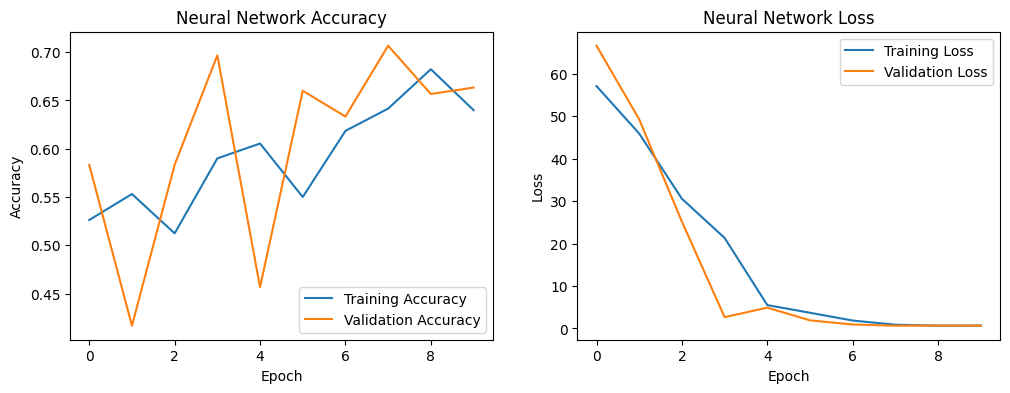

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()